In [48]:
%matplotlib inline
from IPython import display
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import astropy.units as u

In [49]:
prefix = '1to13'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
log_path = path + 'log/'
plots_path = path + 'plots_filt/'

In [62]:
from scipy import stats
df = pd.read_csv(log_path + prefix + '_flare_out.csv')
df_param = pd.read_csv(log_path + prefix + '_param_out.csv')
df['pvalue'] = 1 - stats.chi2(1).cdf(df['g_chisq'] - df['f_chisq'])
mask = (df['skew'] > 0.5) & (df['f_chisq'] > 0) & (df['f_fwhm_win'] < 0.1) &  (df['ed'] > 0) &\
       (df['tpeak'] > df['t0']) & (df['tpeak'] < df['t1']) & (df['cover'] > 0.9) & (df['pvalue'] < 0.05)  & (df['f_chisq'] < 10)
print(len(df), len(np.unique(df['file'])), len(df[mask]), len(np.unique(df[mask]['file'])))

df_flare = df[mask]
flare_files = np.unique(df_flare['file'])

393304 51594 2547 1738


In [63]:
def disp_fl(filename):
    lc_file = plots_path + filename + '.png'
    flare_file = plots_path + filename + '_flares.png'
    display.display(filename)
    display.display(display.Image(lc_file))
    display.display(display.Image(flare_file))

In [64]:
# Compare with Tu 2019
TIC1 = 121011020 # Should be a detection at t=1431
TIC2 = 231631019 # Should be a detection at 1343, but very weak and didnt follow psf
TIC3 = 43472154 # 200 superflares / yr
df_flare[df_flare['TIC'] == TIC1][['f_chisq', 'g_chisq']]

,f_chisq,g_chisq


In [65]:
#disp_fl(df['file'].iloc[0])

In [66]:
# Measure flare energies from GAIA data
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
df_flare_g = pd.merge(tic_gaia_table, df_flare, on='TIC', how='inner')
df_flare_g = df_flare_g.dropna(subset=['lum'])
ed = (df_flare_g['ed'].values*u.day).to(u.s)
energy = (ed*df_flare_g['lum']*u.erg/u.s).value
df_flare_g['energy'] = energy
print(len(df_flare), len(df_flare_g))

2547 1976


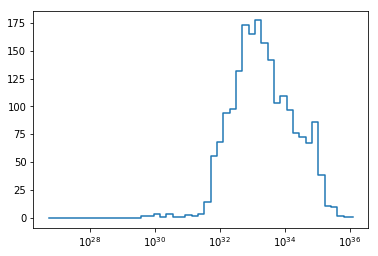

In [67]:
en = df_flare_g['energy']
logbins = np.logspace(np.log10(np.min(en)), np.log10(np.max(en)))
hist, bins = np.histogram(en, bins=logbins)
bins = 0.5*(bins[1:] + bins [:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')

In [68]:
# Seems like there are a lot of high energy flares, is something going wrong with the pipelie or cut?

In [69]:
# Sort rows by energy (top = highest)
energy_ind = np.argsort(df_flare_g['energy'].values)[::-1]
df = df_flare_g.iloc[energy_ind]

1662.6096958484586


'tess2019169103026-s0013-0000000370134610-0146-s_lc.fits'

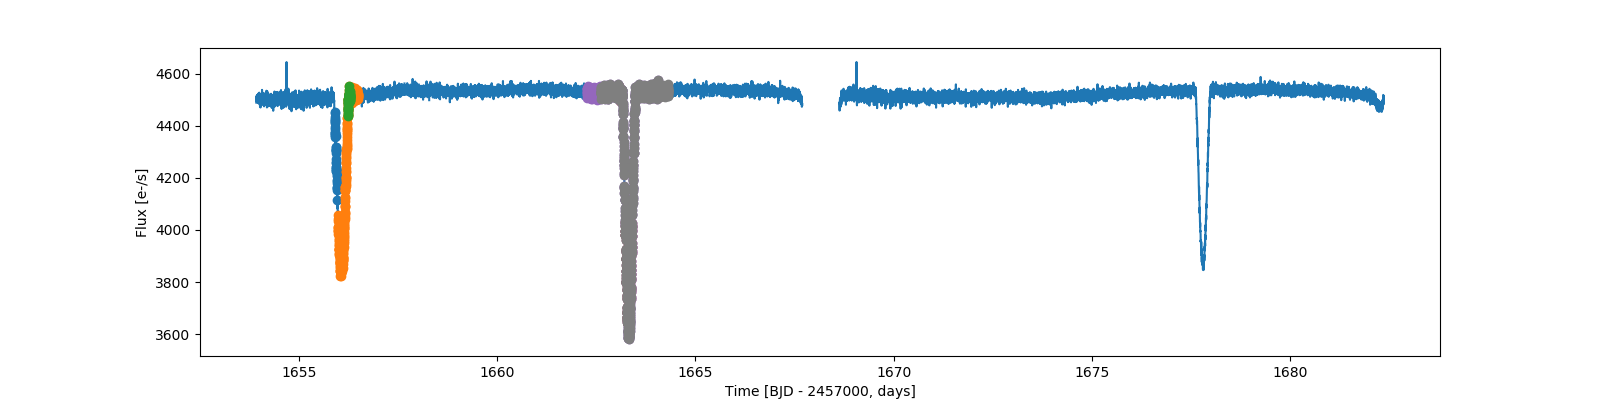

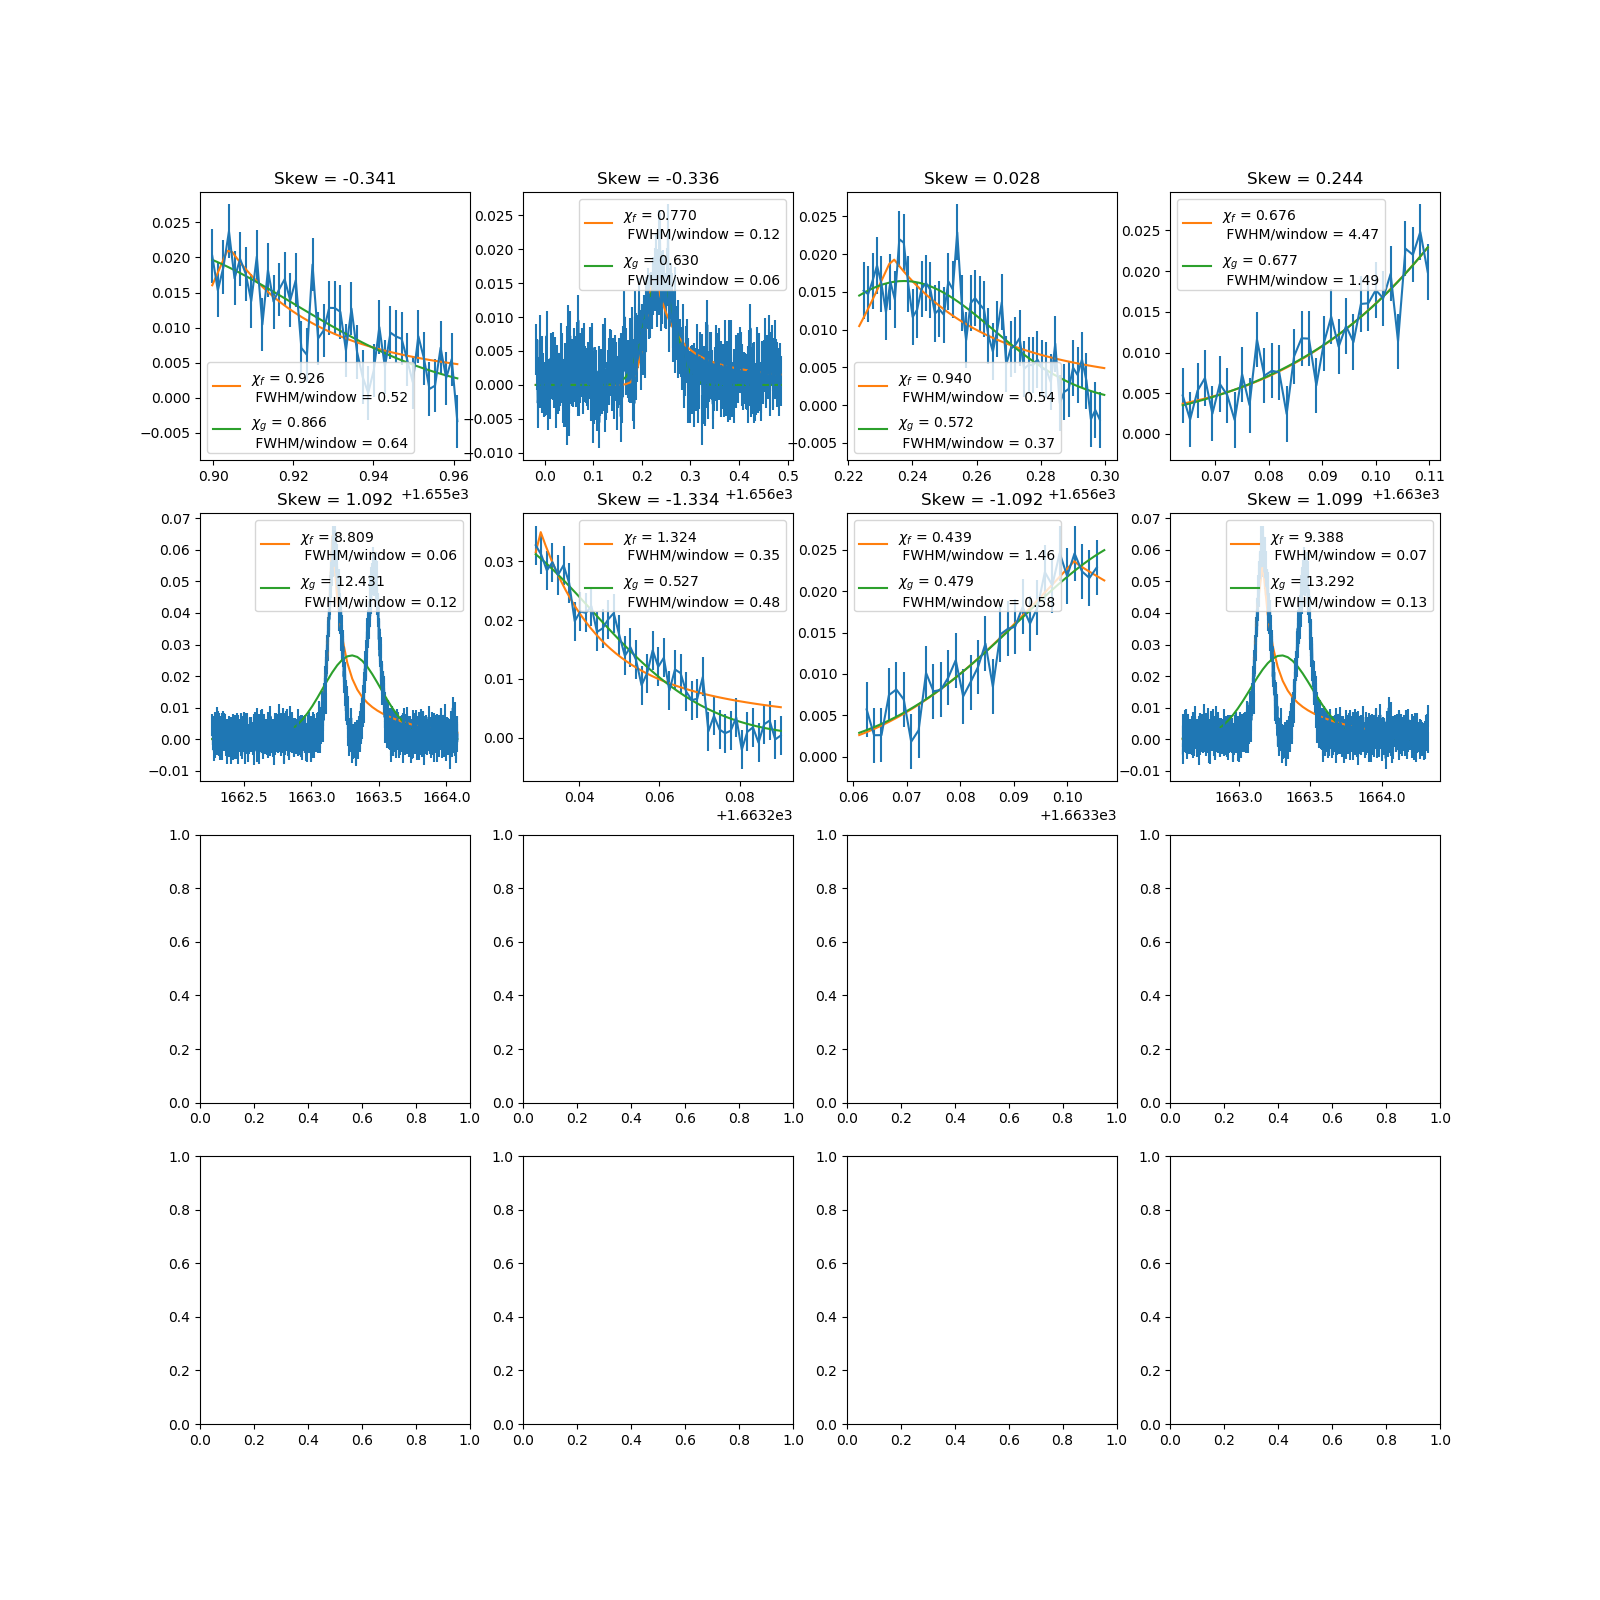

In [71]:
ind = 1
filename = df.iloc[ind]['file']
print(df.iloc[ind]['t0'])
disp_fl(filename)

In [ ]:
# It looks like a lot of the 'double bump' features are eluding our cuts. What if I mask out all other points detected by the CPA
# when fitting a flare?